## CUNEF

### Master Universitario en Ciencia de Datos

**Dep:**
Aprendizaje Automatico

**Practica 3**\
Yelp Analysis

### Case of Study:
Create a model that is able to identify from a text reviews, if the score assigned in a review is a good score or a bad score depending if the star given was 1 o 5.

We are going to take into consideration the accuracy of each model to verify which is the best one to use. We select the accuracy as a parameter to measure which was the best model as we want to verify which model is better predicting correctly the outcome stars. 

### Import the libraries that we are going to use and define the functions that will be used

In [1]:
# Import required libraries
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, mean_squared_error, fbeta_score, r2_score, roc_auc_score
from sklearn.model_selection import train_test_split

import pickle
import warnings
warnings.filterwarnings('ignore')

C:\Users\karla\anaconda3\envs\yelp_env\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Functions to be used
def evaluate_model(y_val, ypred, ypred_proba = None):
    if ypred_proba is not None:
        print('ROC-AUC score of the model: {}'.format(roc_auc_score(y_val, ypred_proba[:, 1])))
        print(f'\nF2 Score: {fbeta_score(y_val, ypred, beta=2, average="macro")}\n')
        print(f'R2 Score: {r2_score(y_val, ypred)}\n')
        print('Accuracy of the model: {}\n'.format(accuracy_score(y_val, ypred)))
        print('Classification report: \n{}\n'.format(classification_report(y_val, ypred)))

# 1. LOADING THE DATASETS

In [3]:
# Reading the dataset
reviews = pd.read_parquet('../00_data/01_process/reviews_data.parquet')
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6985581 entries, 0 to 6985580
Data columns (total 8 columns):
 #   Column       Dtype         
---  ------       -----         
 0   user_id      object        
 1   business_id  object        
 2   stars        float64       
 3   useful       int32         
 4   funny        int32         
 5   cool         int32         
 6   text         object        
 7   date         datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int32(3), object(3)
memory usage: 346.4+ MB


# 2. Pre Processing (Previous steps to modeling)

- Now, we will build a series of models to classify reviews as positive or negative. To do this, we will select only "1" and "5" star reviews to train our models and then split the data set into X and Y variables.

In [4]:
text = reviews[['stars','text']]
print(text.shape)
text.head(5)

(6985581, 2)


,stars,text
0,3.0,"If you decide to eat here, just be aware it is..."
1,5.0,I've taken a lot of spin classes over the year...
2,3.0,Family diner. Had the buffet. Eclectic assortm...
3,5.0,"Wow! Yummy, different, delicious. Our favo..."
4,4.0,Cute interior and owner (?) gave us tour of up...


- The size of the dataset is too large for modeling and it would take hours, so we thought we would take a sample of the first 100,000 reviews of the dataset to build the models.

In [5]:
text = text.iloc[0:100000]

In [6]:
select_stars = text[(text['stars']==1) | (text['stars']==5)]

In [7]:
# Divide the dataset into the complete data and the target dataset
X = select_stars['text']
y = select_stars['stars']

### Count Vectorizer

- It's used to convert a given text into a vector from a frequency count of each word of the complete text. That is, the value of each cell is nothing more than the number of words in the text in question.

In [8]:
count_vec = CountVectorizer().fit(X)
X = count_vec.transform(X)

In [9]:
print("Shape of the sparse matrix: ", X.shape)

Shape of the sparse matrix:  (55353, 51345)


In [10]:
# Division de los datos en train val y test.
x_train, x_val, y_train, y_val = train_test_split(X, y, stratify = y, test_size=0.25,  random_state=0)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, stratify = y_train, test_size=0.25,  random_state=0)

- Save the dataset

In [11]:
with open('../04_modelos/x_train.pickle', 'wb') as f:
    pickle.dump(x_train, f)
with open('../04_modelos/y_train.pickle', 'wb') as f:
    pickle.dump(y_train, f)    
with open('../04_modelos/x_test.pickle', 'wb') as f:
    pickle.dump(x_test, f)
with open('../04_modelos/y_test.pickle', 'wb') as f:
    pickle.dump(y_test, f)

# 3. Identify the best model for our project

### 3.1 Multinomial Naive Bayes

In [12]:
mnb = MultinomialNB()

#Training values
mnb.fit(x_train,y_train)

MultinomialNB()

- This is important, we have not set a seed because there is no random_state hyperparameter in the multinomial naive bayes model.

In [13]:
with open('../04_modelos/mnb_model.pickle', 'wb') as f:
    pickle.dump(mnb, f)

In [14]:
# Predict values
mnb_pred = mnb.predict(x_val)
ypred_proba = mnb.predict_proba(x_val)
evaluate_model(y_val,mnb_pred,ypred_proba)

ROC-AUC score of the model: 0.9761991824676385

F2 Score: 0.9207866248406509

R2 Score: 0.6609678676985812

Accuracy of the model: 0.9462388900932148

Classification report: 
              precision    recall  f1-score   support

         1.0       0.85      0.89      0.87      2735
         5.0       0.97      0.96      0.97     11104

    accuracy                           0.95     13839
   macro avg       0.91      0.92      0.92     13839
weighted avg       0.95      0.95      0.95     13839




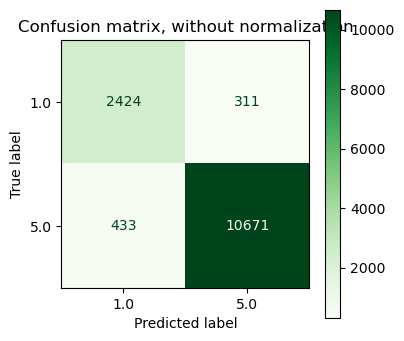

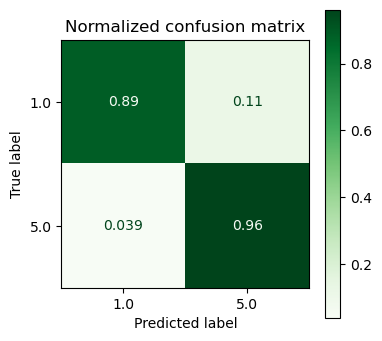

In [15]:
titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
        fig, ax = plt.subplots(figsize=(4, 4))
        disp = ConfusionMatrixDisplay.from_predictions(y_val, mnb_pred,
                                                       cmap=plt.cm.Greens,
                                                       normalize=normalize,
                                                       ax=ax)
        ax.set_title(title)

**Insights:**

The Multinomial Naive Bayes model has an accuracy of 94.62%, This represents a good accuracy for the model to predict whether a specific text can be consider as a 5 stars review or as a 1 star review. The model was able to correctly predict the 96% of all the texts that were classified as 5 and 89% of all the texts that were scored as 1. Regardless of a good accuracy, this is a model rather simple so we are going to execute more models to later compare each final outcome.

### 3.2 Support Vector Machine

In [16]:
SVM = SVC(probability = True, random_state = 0)

#Training values
SVM.fit(x_train, y_train)

SVC(probability=True, random_state=0)

In [17]:
with open('../04_modelos/SVM_model.pickle', 'wb') as f:
    pickle.dump(SVM, f)

In [18]:
# Predict values
SVM_pred = SVM.predict(x_val)
ypred_proba = SVM.predict_proba(x_val)
evaluate_model(y_val,SVM_pred,ypred_proba)

ROC-AUC score of the model: 0.9899360014540934

F2 Score: 0.9276465010889324

R2 Score: 0.7593965512699609

Accuracy of the model: 0.9618469542597008

Classification report: 
              precision    recall  f1-score   support

         1.0       0.95      0.85      0.90      2735
         5.0       0.97      0.99      0.98     11104

    accuracy                           0.96     13839
   macro avg       0.96      0.92      0.94     13839
weighted avg       0.96      0.96      0.96     13839




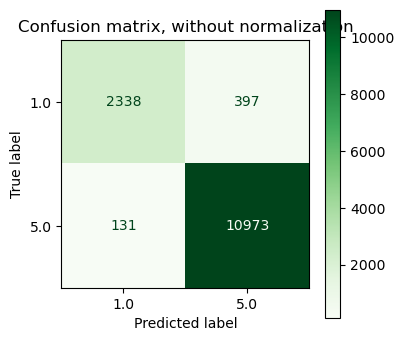

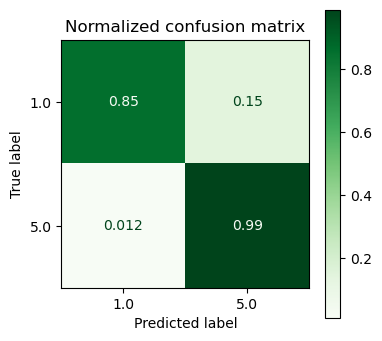

In [19]:
titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
        fig, ax = plt.subplots(figsize=(4, 4))
        disp = ConfusionMatrixDisplay.from_predictions(y_val, SVM_pred,
                                                       cmap=plt.cm.Greens,
                                                       normalize=normalize,
                                                       ax=ax)
        ax.set_title(title)

**Insights:**

The SVM model has an accuracy of 96.18% and a r2 of 0.75. Comparing this model with the Multinomial Naive Bayes, the results were better regarding both accuracy and r2. Which means that the model was better identifying the text classification and with less variation than the first naive bayers model. 

 The model was able to correctly predict the 99% of all the texts that were classified as 5 and 85% of all the texts that were scored as 1.

### 3.3 Decission Tree

In [20]:
dt = DecisionTreeClassifier(random_state = 0)

#Training values
dt.fit(x_train,y_train)

DecisionTreeClassifier(random_state=0)

In [21]:
with open('../04_modelos/dt_model.pickle', 'wb') as f:
    pickle.dump(dt, f)

In [22]:
# Predict values
dt_pred = dt.predict(x_val)
ypred_proba = dt.predict_proba(x_val)
evaluate_model(y_val,dt_pred,ypred_proba)

ROC-AUC score of the model: 0.839667030409517

F2 Score: 0.8388410903298282

R2 Score: 0.3465429062900073

Accuracy of the model: 0.8963797962280512

Classification report: 
              precision    recall  f1-score   support

         1.0       0.73      0.75      0.74      2735
         5.0       0.94      0.93      0.94     11104

    accuracy                           0.90     13839
   macro avg       0.84      0.84      0.84     13839
weighted avg       0.90      0.90      0.90     13839




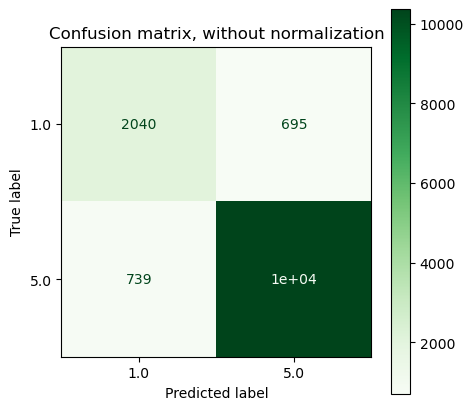

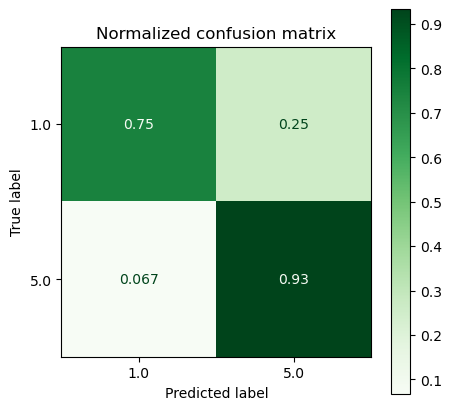

In [23]:
titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
        fig, ax = plt.subplots(figsize=(5, 5))
        disp = ConfusionMatrixDisplay.from_predictions(y_val, dt_pred,
                                                       cmap=plt.cm.Greens,
                                                       normalize=normalize,
                                                       ax=ax)
        ax.set_title(title)

**Insights:**

The Decission Tree model has an accuracy of 89.63% which is the worst accuracy from the models performed until this point. Where the model had more issuess was with the prediction of the text reviews that were 1, which the model was just able to identify it 75% of the times with a 25% of the times incorrectly assigning 5 stars wheere in fact it was a 1 star review.

### 3.4 Logistic Regression

In [24]:
LR = LogisticRegression(penalty = 'none', random_state = 0)

# Training values
LR.fit(x_train,y_train)

LogisticRegression(penalty='none', random_state=0)

In [25]:
with open('../04_modelos/LR_model.pickle', 'wb') as f:
    pickle.dump(LR, f)

In [26]:
# Predict values
LR_pred = LR.predict(x_val)
ypred_proba = LR.predict_proba(x_val)
evaluate_model(y_val,LR_pred,ypred_proba)

ROC-AUC score of the model: 0.9696668097930025

F2 Score: 0.9428109256599975

R2 Score: 0.7794468386641308

Accuracy of the model: 0.9650263747380591

Classification report: 
              precision    recall  f1-score   support

         1.0       0.92      0.90      0.91      2735
         5.0       0.98      0.98      0.98     11104

    accuracy                           0.97     13839
   macro avg       0.95      0.94      0.94     13839
weighted avg       0.96      0.97      0.96     13839




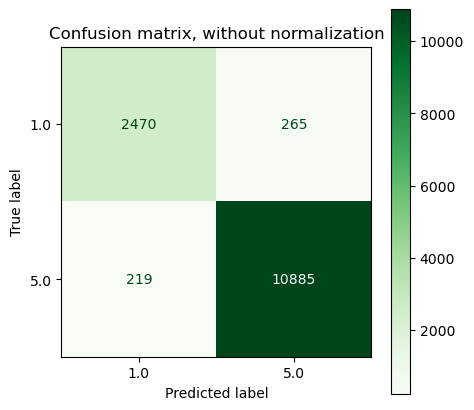

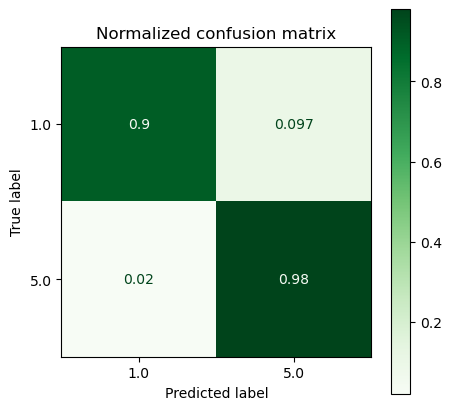

In [27]:
titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
        fig, ax = plt.subplots(figsize=(5, 5))
        disp = ConfusionMatrixDisplay.from_predictions(y_val, LR_pred,
                                                       cmap=plt.cm.Greens,
                                                       normalize=normalize,
                                                       ax=ax)
        ax.set_title(title)

**Insights**

The logistic regressor model is the one with the best results so far with an accuracy of 96.5 and a r2 of 77.9. Thhe model was correctly classify 98% of all the text reviews that were 5 and 90% of the text reviews that were 1. This model is good classifieng both text that have a 5 stars reviews and texts that have a 1 star review.

### 3.5 Random Forest

In [28]:
rf = RandomForestClassifier(random_state = 0)

#Training values
rf.fit(x_train,y_train)

RandomForestClassifier(random_state=0)

In [29]:
with open('../04_modelos/rf_model.pickle', 'wb') as f:
    pickle.dump(rf, f)

In [30]:
# Predict values
rf_pred = rf.predict(x_val)
ypred_proba = rf.predict_proba(x_val)
evaluate_model(y_val,rf_pred,ypred_proba)

ROC-AUC score of the model: 0.9780630792006701

F2 Score: 0.8046449121287984

R2 Score: 0.4604649937568819

Accuracy of the model: 0.9144446853096322

Classification report: 
              precision    recall  f1-score   support

         1.0       0.98      0.58      0.73      2735
         5.0       0.91      1.00      0.95     11104

    accuracy                           0.91     13839
   macro avg       0.94      0.79      0.84     13839
weighted avg       0.92      0.91      0.91     13839




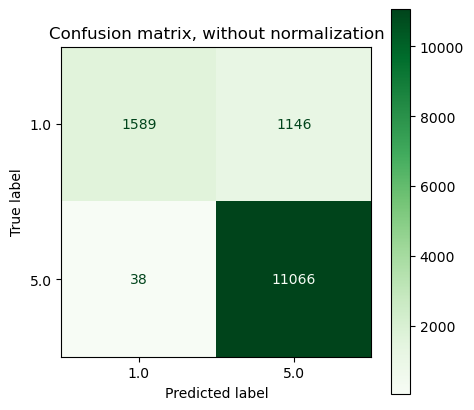

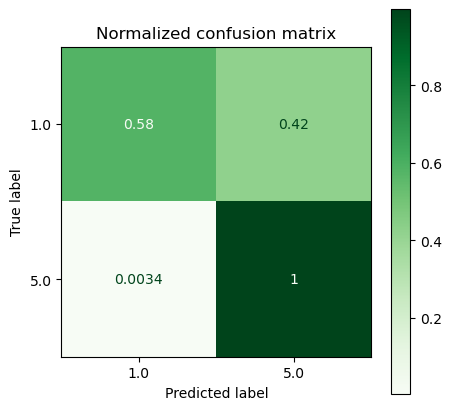

In [31]:
titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
        fig, ax = plt.subplots(figsize=(5, 5))
        disp = ConfusionMatrixDisplay.from_predictions(y_val, rf_pred,
                                                       cmap=plt.cm.Greens,
                                                       normalize=normalize,
                                                       ax=ax)
        ax.set_title(title)

**Insights**
The random forest is the model that is best identifying the text and rating it as a 5 star reviews Regardless the modelit is not good classifying text for a star review of 1. Only the 58% of all the cases where the texts were refering to a star review of 1, the model was able to predict it. 

Because of that, the accuracy of the model is 91.44% with a low r2 of 46.04%. This is not a good model to put into production as it is skewed to give more 5 stars to the reviews that analyze.

# 4. Summary of the models and final choice of the model to be optimized

In [32]:
algos_countvec=["Mult Naive Bayes", "Support Vector Machine", "Decision Tree", "Logistic Regression", "Random Forest"]
predictions_countvec= [round(accuracy_score(y_val,mnb_pred)*100,2),
                       round(accuracy_score(y_val,SVM_pred)*100,2),
                       round(accuracy_score(y_val,dt_pred)*100,2),
                       round(accuracy_score(y_val,LR_pred)*100,2),
                       round(accuracy_score(y_val,rf_pred)*100,2)]

<AxesSubplot: >

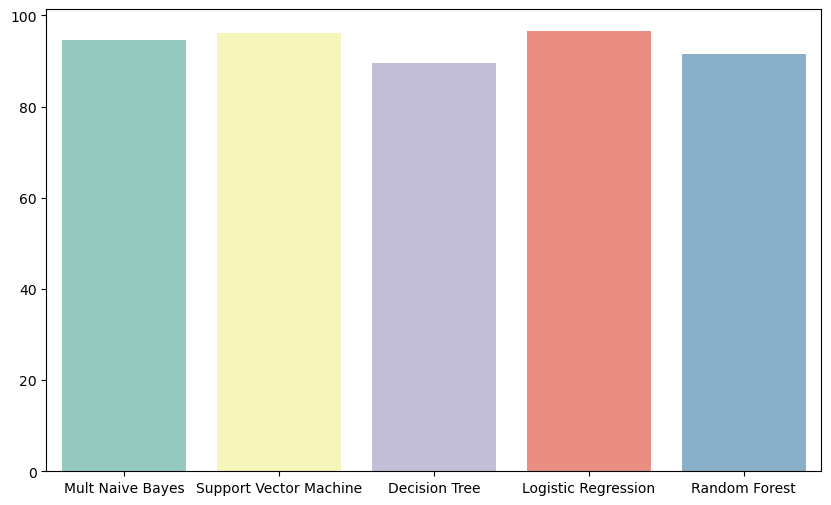

In [33]:
plt.figure(figsize = (10,6))
sns.barplot(y = predictions_countvec, x = algos_countvec, palette = 'Set3')

## Conclusion

From the models that were executed with the dataset or review where the target was to create a model that correctly classify if a text of a review was a possitive star score (5) or a bad star score (1), it was able to identify that the best model amoung all was the logistic regression with a accuracy of 96.5% and r2 of 77%. 

This was the best model in both accuracy and recall. Therefore we are going to select this base model and will adjust the hyperparameters to increase the models ability to classify a text and assign a score star of good or bad. 